In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [5]:
data_model_predictions = pd.read_parquet('data_clean/data_model_predictions.pq')

train, test = train_test_split(data_model_predictions,test_size=0.5)
train

FileNotFoundError: [Errno 2] No such file or directory: 'data_clean/data_model_predictions.pq'

Text(0.5, 1.0, 'The distribution women and men')

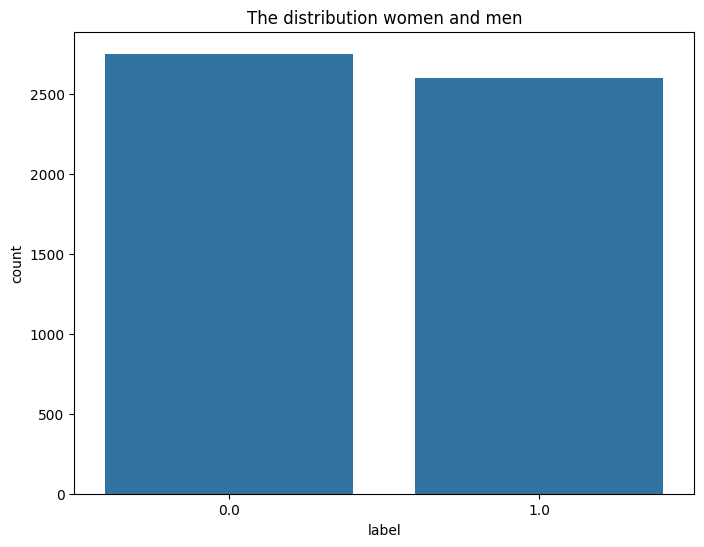

In [177]:
plt.figure(figsize=(8,6))
sns.barplot(train['label'].value_counts())
plt.title('The distribution women and men')

In [178]:
# Defining pre-processing parameters
max_len = 50 
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

In [179]:
x_train, x_test, y_train, y_test = train_test_split(data_model['message'], data_model['label'].values,
                                                    test_size=0.2, random_state=434)

In [180]:
tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words


training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)


testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)


print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (8564, 50)
Shape of testing tensor:  (2141, 50)


In [181]:
# Define parameter
vocab_size = 500 
embedding_dim = 128
drop_value = 0.2
n_dense = 128
# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs, 
                    validation_split = 0.15,
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/30
228/228 - 1s - loss: 0.3049 - accuracy: 0.9111 - val_loss: 0.0215 - val_accuracy: 0.9969 - 1s/epoch - 6ms/step
Epoch 2/30
228/228 - 1s - loss: 0.0141 - accuracy: 0.9964 - val_loss: 0.0082 - val_accuracy: 0.9977 - 640ms/epoch - 3ms/step
Epoch 3/30
228/228 - 1s - loss: 0.0076 - accuracy: 0.9979 - val_loss: 0.0056 - val_accuracy: 0.9984 - 515ms/epoch - 2ms/step
Epoch 4/30
228/228 - 1s - loss: 0.0053 - accuracy: 0.9989 - val_loss: 0.0049 - val_accuracy: 0.9984 - 520ms/epoch - 2ms/step
Epoch 5/30
228/228 - 0s - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.0036 - val_accuracy: 0.9984 - 494ms/epoch - 2ms/step
Epoch 6/30
228/228 - 1s - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0019 - val_accuracy: 0.9992 - 521ms/epoch - 2ms/step
Epoch 7/30
228/228 - 1s - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.0016 - val_accuracy: 0.9992 - 531ms/epoch - 2ms/step
Epoch 8/30
228/228 - 1s - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0023 - val_accuracy: 0.9992 - 702ms/epoch - 3ms/step
Epo

In [182]:
train_dense_results = model.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
test_dense_results = model.evaluate(testing_padded, y_test)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {test_dense_results[1]*100:0.2f}')
print(f'Test accuracy: {test_dense_results[1]*100:0.2f}')

34/34 - 0s - loss: 5.8340e-04 - accuracy: 0.9999 - 213ms/epoch - 6ms/step
67/67 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Train accuracy: 99.99
Valid accuracy: 100.00
Test accuracy: 100.00


LSTM

In [183]:
# Define parameter
n_lstm = 128
drop_lstm = 0.2
# Define LSTM Model 
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(LSTM(n_lstm, return_sequences=False))
model1.add(Dropout(drop_lstm))
model1.add(Dense(1, activation='sigmoid'))

In [184]:
model1.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_split=0.15,
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
228/228 - 16s - loss: 0.6886 - accuracy: 0.5178 - val_loss: 0.0803 - val_accuracy: 0.9961 - 16s/epoch - 70ms/step
Epoch 2/30
228/228 - 13s - loss: 0.0066 - accuracy: 0.9993 - val_loss: 0.0126 - val_accuracy: 0.9984 - 13s/epoch - 56ms/step
Epoch 3/30
228/228 - 13s - loss: 0.0040 - accuracy: 0.9996 - val_loss: 0.0131 - val_accuracy: 0.9984 - 13s/epoch - 55ms/step
Epoch 4/30
228/228 - 12s - loss: 0.0041 - accuracy: 0.9996 - val_loss: 0.0070 - val_accuracy: 0.9992 - 12s/epoch - 53ms/step
Epoch 5/30
228/228 - 13s - loss: 0.0039 - accuracy: 0.9996 - val_loss: 0.0132 - val_accuracy: 0.9984 - 13s/epoch - 57ms/step
Epoch 6/30
228/228 - 12s - loss: 0.0037 - accuracy: 0.9996 - val_loss: 0.0070 - val_accuracy: 0.9992 - 12s/epoch - 55ms/step
Epoch 7/30
228/228 - 13s - loss: 0.0037 - accuracy: 0.9996 - val_loss: 0.0071 - val_accuracy: 0.9992 - 13s/epoch - 57ms/step
Epoch 8/30
228/228 - 13s - loss: 0.0027 - accuracy: 0.9997 - val_loss: 0.0069 - val_accuracy: 0.9992 - 13s/epoch - 55ms/step


In [185]:
train_dense_results = model1.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
test_dense_results = model1.evaluate(testing_padded, y_test)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Test accuracy: {test_dense_results[1]*100:0.2f}')

34/34 - 3s - loss: 0.0032 - accuracy: 0.9996 - 3s/epoch - 84ms/step
67/67 [==============================] - 2s 28ms/step - loss: 0.0078 - accuracy: 0.9991
Train accuracy: 99.96
Test accuracy: 99.91


testing on unsupervised data

In [ ]:
data_model = pd.read_csv('data/data_unsupervised.csv',index_col= 0).set_index('id',append=True)
# data_model.columns = ['message','label']
x_unlabel = data_model['X']


unsupervised_sequences = tokenizer.texts_to_sequences(x_unlabel)
unsupervised_padded = pad_sequences(unsupervised_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [ ]:
predictions = model.predict(unsupervised_padded)
unsupervised_pred = pd.DataFrame(predictions,columns = ['pred'],index = data_model.index)
sns.kdeplot(unsupervised_pred['pred'], bw_adjust=0.5, fill=True)
data_model['pred'] = unsupervised_pred['pred']
data_model['label_approx'] = data_model['X'].apply(lambda x :0 if 'femme' in x else 1)
data_model['pred_label']= data_model['pred'].apply(lambda x : 1 if x >0.5 else 0)
data_model[(data_model['X'].str.contains('homme')) & (data_model['pred_label']==0)]
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(data_model['label_approx'], data_model['pred_label'], labels=[0,1])
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['femme','homme'])
disp.plot(values_format='d', cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.show()
clean_data = pd.read_csv('data/data_clean.csv',index_col=[0,1])
clean_data = clean_data.join(data_model,how = 'inner')
accuracy_score(clean_data['label_approx'],clean_data['pred_label'])

# BI LSTM

In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model2.add(Bidirectional(LSTM(n_lstm,
                              return_sequences = False)))
model2.add(Dropout(drop_lstm))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])

In [ ]:
num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
history = model2.fit(training_padded,
                     y_train,
                     epochs = num_epochs,
                     validation_split = 0.15,
                     callbacks = [early_stop],
                     verbose = 2)

228/228 - 29s - loss: 0.1008 - accuracy: 0.9683 - val_loss: 0.0072 - val_accuracy: 0.9992 - 29s/epoch - 127ms/step
Epoch 2/30
228/228 - 25s - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.0022 - val_accuracy: 0.9992 - 25s/epoch - 110ms/step
Epoch 3/30
228/228 - 26s - loss: 0.0018 - accuracy: 0.9999 - val_loss: 6.2316e-04 - val_accuracy: 1.0000 - 26s/epoch - 112ms/step
Epoch 4/30
228/228 - 29s - loss: 6.9299e-04 - accuracy: 0.9999 - val_loss: 2.0906e-04 - val_accuracy: 1.0000 - 29s/epoch - 126ms/step
Epoch 5/30
228/228 - 27s - loss: 1.6806e-04 - accuracy: 1.0000 - val_loss: 1.2744e-04 - val_accuracy: 1.0000 - 27s/epoch - 117ms/step
Epoch 6/30
228/228 - 24s - loss: 9.5741e-05 - accuracy: 1.0000 - val_loss: 1.1751e-04 - val_accuracy: 1.0000 - 24s/epoch - 105ms/step
Epoch 7/30
228/228 - 23s - loss: 6.8983e-05 - accuracy: 1.0000 - val_loss: 8.9087e-05 - val_accuracy: 1.0000 - 23s/epoch - 100ms/step
Epoch 8/30
228/228 - 23s - loss: 5.3996e-05 - accuracy: 1.0000 - val_loss: 7.7464e-05 - val_a

In [ ]:
train_dense_results = model2.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
test_dense_results = model2.evaluate(testing_padded, y_test)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Test accuracy: {test_dense_results[1]*100:0.2f}')

34/34 - 6s - loss: 2.2791e-05 - accuracy: 1.0000 - 6s/epoch - 180ms/step
67/67 [==============================] - 3s 39ms/step - loss: 2.1143e-05 - accuracy: 1.0000
Train accuracy: 100.00
Test accuracy: 100.00


449/449 [==============================] - 8s 16ms/step


<Axes: xlabel='pred', ylabel='Density'>

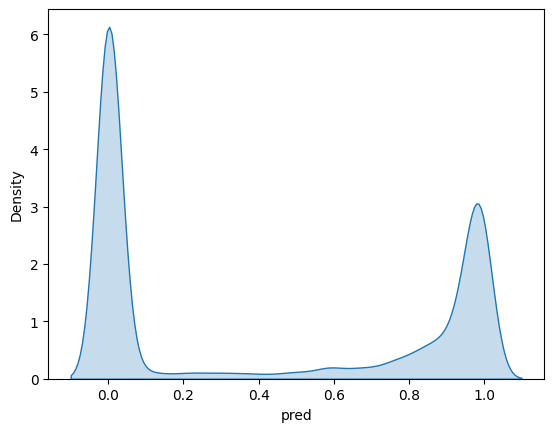

In [ ]:
predictions = model2.predict(unsupervised_padded)
unsupervised_pred = pd.DataFrame(predictions,columns = ['pred'],index = data_model.index)
sns.kdeplot(unsupervised_pred['pred'], bw_adjust=0.5, fill=True)


In [ ]:
data_model['pred'] = unsupervised_pred['pred']
data_model['label_approx'] = data_model['X'].apply(lambda x :0 if 'femme' in x else 1)
data_model['pred_label']= data_model['pred'].apply(lambda x : 1 if x >0.5 else 0)


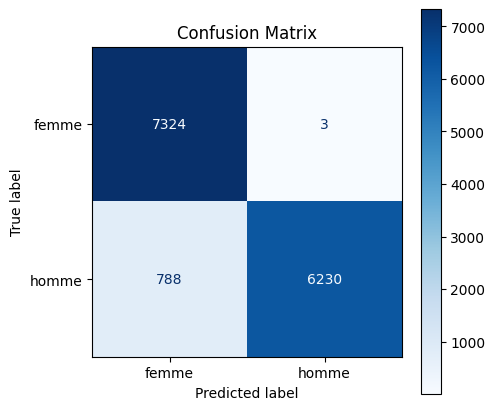

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(data_model['label_approx'], data_model['pred_label'], labels=[0,1])
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['femme','homme'])
disp.plot(values_format='d', cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.show()
clean_data = pd.read_csv('data/data_clean.csv',index_col=[0,1])
clean_data = clean_data.join(data_model,how = 'inner')


In [ ]:
accuracy_score(clean_data['label_approx'],clean_data['pred_label'])

0.9448588358313001